## POOL UMA_FEI

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 80

X_NAME = 'UMA'
Y_NAME = 'FEI'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,4,FEI,UMA,29763.930711,0.0,2014.242356,119.055723,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,7.0,2021-11-23 23:19:32,2021-11-23 23:19:21,0x9545c5bc50defba38e1cb3d15efdbeb5ab81912e06fa...,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4,549472.610295,8.008752e+06,4.400590e+12,0,0,False,547458.367939,8.038397e+06,4.400688e+12,0,0,False,14.683120,0.007394
1,5,FEI,UMA,14991.490675,0.0,1008.928861,59.965963,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,13.0,2021-11-23 23:21:02,2021-11-23 23:20:54,0x4756c2afc0a426a358fc48596b1105458296d08bae40...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,5,547458.367939,8.038397e+06,4.400688e+12,0,0,False,546449.439078,8.053329e+06,4.400737e+12,1321,6,False,14.737555,0.003707
2,6,FEI,UMA,14923.378191,0.0,1000.647021,59.693513,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,403.0,2021-11-24 00:58:32,2021-11-24 00:58:28,0xec06f0c0627a48c286675dab3b52b12162e276fdc1c7...,0x8698d9d5ea99809c00426484a80be2add4e54581,0x157dfa656fdf0d18e1ba94075a53600d81cb3a97,6,546449.439078,8.053329e+06,4.400737e+12,1321,6,False,545448.792057,8.068192e+06,4.400786e+12,87536,403,False,14.791842,0.003684
3,7,UMA,FEI,997.650000,0.0,14583.103737,58.332415,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,841.0,2021-11-24 02:48:02,2021-11-24 02:47:58,0xf5bb16d17347ac05b7cb88082d2ccba93a35193b4372...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,7,545448.792057,8.068192e+06,4.400786e+12,87536,403,False,546446.442057,8.053551e+06,4.400834e+12,184718,847,False,14.738042,-0.003637
4,8,UMA,FEI,1448.948091,0.0,21085.760194,84.343041,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1019.0,2021-11-24 03:32:32,2021-11-24 03:32:20,0xfee2383f6e7cc0d6cb0f53229dc636cb0dc756112e31...,0x8698d9d5ea99809c00426484a80be2add4e54581,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,8,546446.442057,8.053551e+06,4.400834e+12,184718,847,False,547895.390148,8.032381e+06,4.400904e+12,224069,1028,False,14.660428,-0.005266


In [9]:
swaps0_df.status.value_counts()

SUCCESS    26
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS    26
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                25
CANT_CONSULT_ORACLE     1
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.038461538461538464


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
Series([], Name: status, dtype: int64)

Burns status with volatility mitigation mechanism
Series([], Name: status, dtype: int64)


**0** have been **blocked by the volatility mitigation mechanism**. In only 0.4% of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (77% without modification)

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

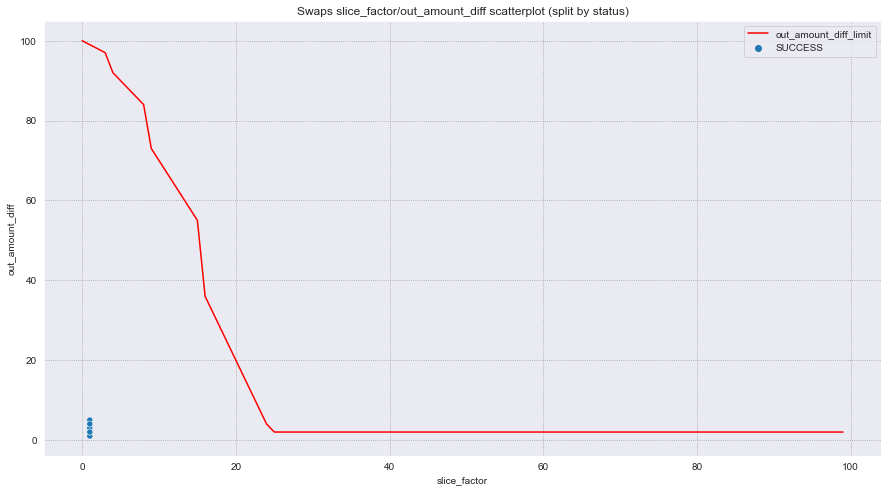

In [15]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be seen that there are more observations than in the initial version, as the volatility mitigation checked much more transactions because of the TWAP availability.**

In [16]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,4,FEI,UMA,29763.930711,0.0,2014.242356,119.055723,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,7.0,2021-11-23 23:19:32,2021-11-23 23:19:21,0x9545c5bc50defba38e1cb3d15efdbeb5ab81912e06fa...,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4,549472.610295,8.008752e+06,4.400590e+12,0,0,False,547458.367939,8.038397e+06,4.400688e+12,0,0,False,14.683120,0.007394
1,5,FEI,UMA,14991.490675,0.0,1008.928861,59.965963,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,13.0,2021-11-23 23:21:02,2021-11-23 23:20:54,0x4756c2afc0a426a358fc48596b1105458296d08bae40...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,5,547458.367939,8.038397e+06,4.400688e+12,0,0,False,546449.439078,8.053329e+06,4.400737e+12,1321,6,False,14.737555,0.003707
2,6,FEI,UMA,14923.378191,0.0,1000.647021,59.693513,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,403.0,2021-11-24 00:58:32,2021-11-24 00:58:28,0xec06f0c0627a48c286675dab3b52b12162e276fdc1c7...,0x8698d9d5ea99809c00426484a80be2add4e54581,0x157dfa656fdf0d18e1ba94075a53600d81cb3a97,6,546449.439078,8.053329e+06,4.400737e+12,1321,6,False,545448.792057,8.068192e+06,4.400786e+12,87536,403,False,14.791842,0.003684
3,7,UMA,FEI,997.650000,0.0,14583.103737,58.332415,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,841.0,2021-11-24 02:48:02,2021-11-24 02:47:58,0xf5bb16d17347ac05b7cb88082d2ccba93a35193b4372...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,7,545448.792057,8.068192e+06,4.400786e+12,87536,403,False,546446.442057,8.053551e+06,4.400834e+12,184718,847,False,14.738042,-0.003637
4,8,UMA,FEI,1448.948091,0.0,21085.760194,84.343041,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1019.0,2021-11-24 03:32:32,2021-11-24 03:32:20,0xfee2383f6e7cc0d6cb0f53229dc636cb0dc756112e31...,0x8698d9d5ea99809c00426484a80be2add4e54581,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,8,546446.442057,8.053551e+06,4.400834e+12,184718,847,False,547895.390148,8.032381e+06,4.400904e+12,224069,1028,False,14.660428,-0.005266
5,9,UMA,FEI,2946.875181,0.0,42543.890095,170.175560,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1023.0,2021-11-24 03:33:32,2021-11-24 03:33:29,0x52ee629a9565a7b0ea163f3903abfc5d59c45542e463...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,9,547895.390148,8.032381e+06,4.400904e+12,224069,1028,False,550842.265329,7.989667e+06,4.401046e+12,224948,1032,False,14.504455,-0.010639
6,10,UMA,FEI,1775.024141,0.0,25407.246362,101.628985,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1832.0,2021-11-24 06:55:47,2021-11-24 06:55:44,0xb3e6b5c9f401d00c1eafe1f0f44407c88e3ba947b5a1...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,10,550842.265329,7.989667e+06,4.401046e+12,224948,1032,False,552617.289470,7.964158e+06,4.401131e+12,400960,1869,False,14.411706,-0.006395
7,11,UMA,FEI,1957.490510,0.0,27831.071547,111.324286,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2581.0,2021-11-24 10:03:02,2021-11-24 10:02:48,0x74bf221fb2d4b73efcec4dc575eddae5b6f287dd13e6...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,11,552617.289470,7.964158e+06,4.401131e+12,400960,1869,False,554574.779980,7.936215e+06,4.401225e+12,562875,2648,False,14.310451,-0.007026
8,12,UMA,FEI,2125.189821,0.0,29994.508361,119.978033,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2609.0,2021-11-24 10:10:02,2021-11-24 10:09:55,0xc554eb631f2770a867f8e1234e4537c44c3a1df948cd...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x27239549dd40e1d60f5b80b0c419692

Text(0, 0.5, 'Count')

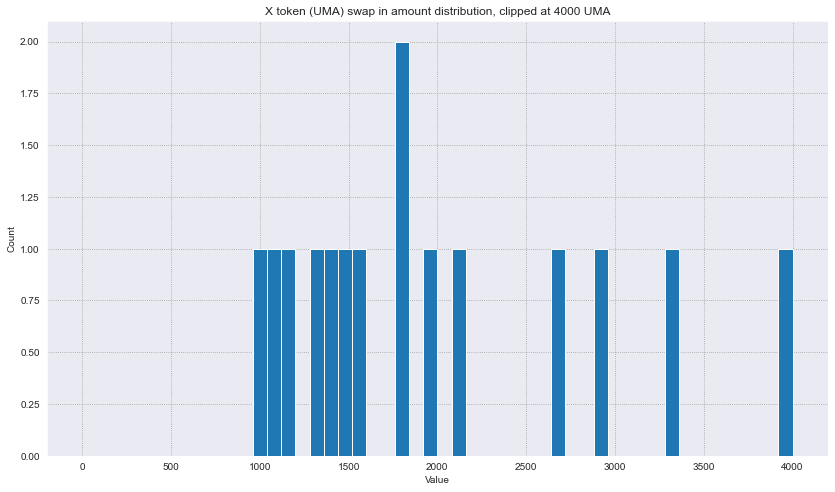

In [18]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

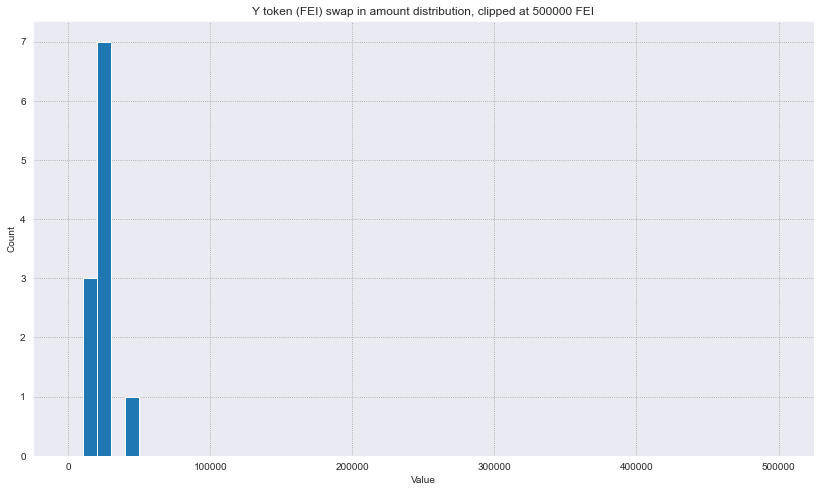

In [19]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

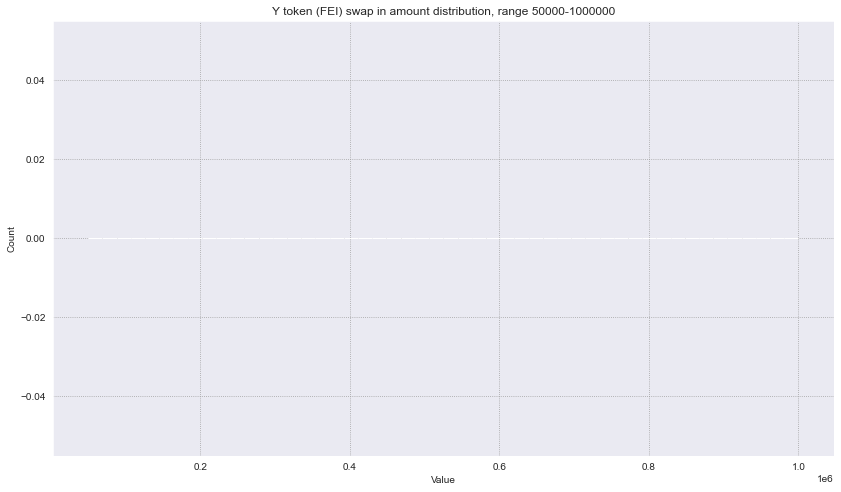

In [20]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

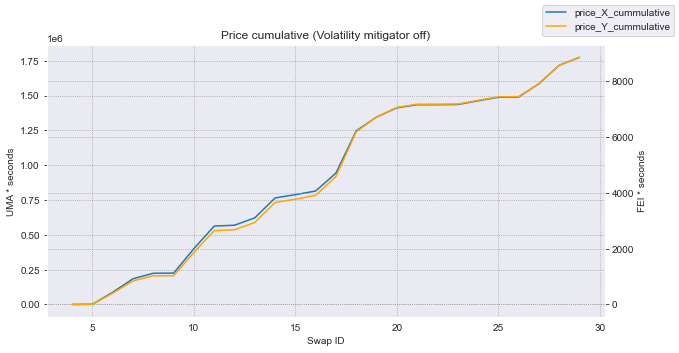

In [21]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

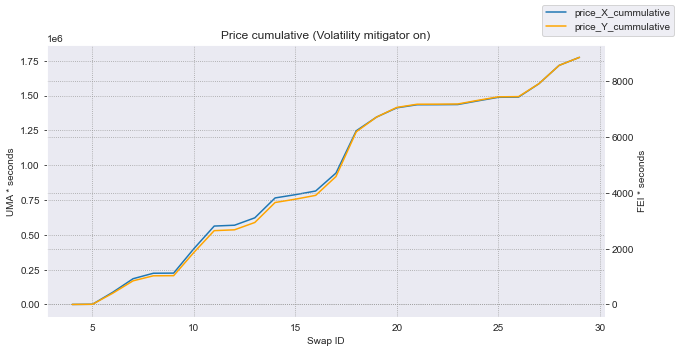

In [22]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

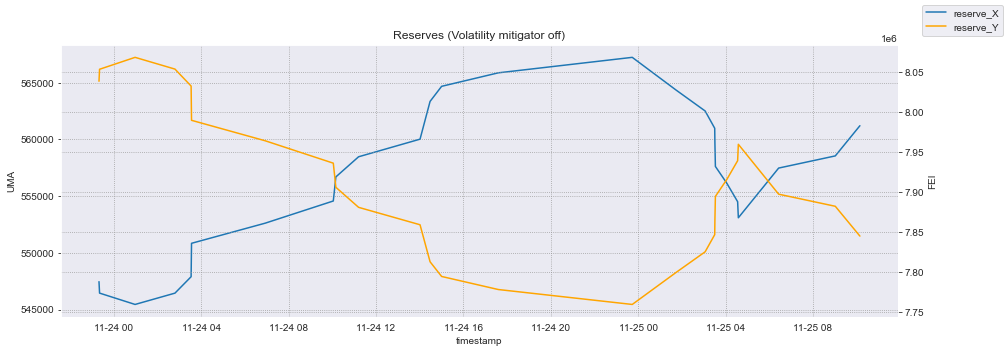

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

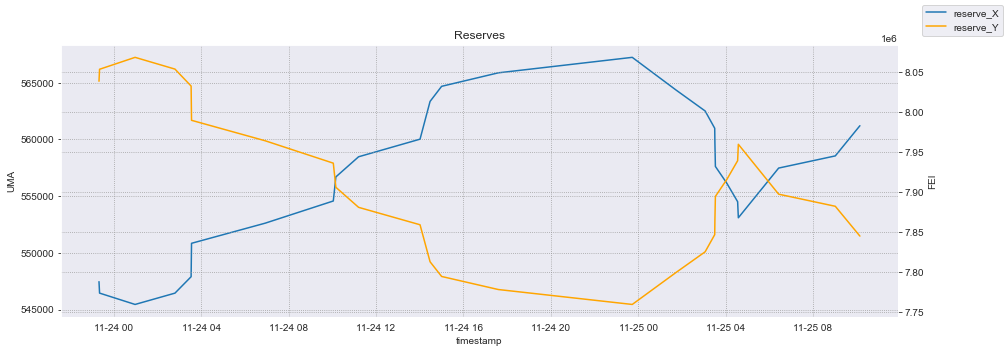

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

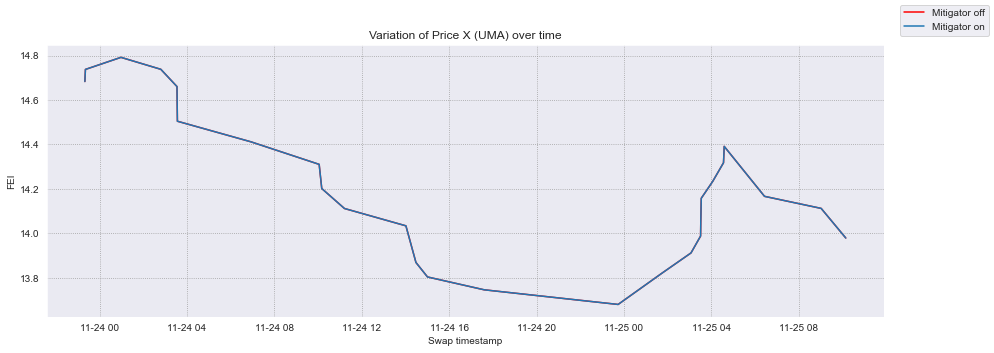

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is the same as in the initial version**

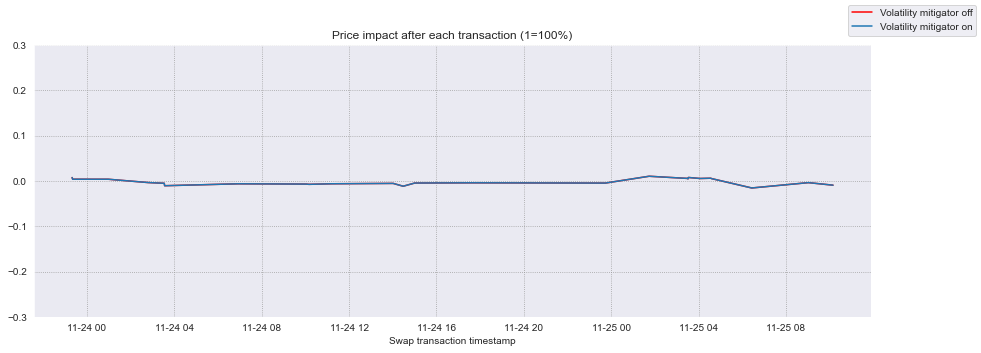

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The price impact after each transaction doesn't exceed 0.25 and is the same as initially**

In [61]:
swaps1_df.iloc[725:750]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff


In [66]:
swaps1_df[swaps1_df.price_diff > 0.4]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
